In [1]:
import pandas as pd
from common import k_means_clustering, visualize_2d, visualize_3d
import torch

In [2]:
import os

os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # to avoid warning from sklearn  

## Read data

In [3]:
file_path = 'features.csv'
df = pd.read_csv(file_path)

In [4]:
df.head()

,Image Name,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,10002702_1960-11-09_2012.jpg,0.272667,0.181304,0.522613,0.985274,0.107050,0.359303,0.275444,0.677732,0.263400,...,0.000000,0.181292,0.383862,0.020063,0.129796,0.336707,0.028761,0.445108,0.010085,0.227951
1,1002001_1944-05-01_1995.jpg,0.279749,0.001916,0.115101,0.893894,0.040134,0.333267,0.071751,0.759813,0.170035,...,0.006483,0.048637,0.739707,0.014779,0.554291,0.208090,0.462767,0.565933,0.023557,0.000000
2,1004604_1981-11-27_2012.jpg,0.191526,0.309201,0.144497,1.417195,0.191475,0.046141,0.252428,0.148858,0.103499,...,0.007329,0.002504,0.347986,0.126279,0.739436,0.297104,0.387431,0.874872,0.032340,0.076012
3,10049200_1891-09-16_1958.jpg,0.382820,0.079980,0.591635,0.931270,0.348299,0.317523,0.126595,0.221747,0.059046,...,0.040913,0.001872,1.560098,0.123703,0.385894,0.007108,0.017871,1.083520,0.023397,0.091238
4,10064003_1986-01-04_2009.jpg,0.865130,0.361720,0.539288,1.447548,0.425298,0.970224,0.440898,0.828271,0.076451,...,0.101955,0.025929,0.740600,0.087209,0.401073,0.026632,0.077148,0.935509,0.135685,0.063321


In [5]:
# get the features into torch tensors
features = df.drop(columns=['Image Name']).values
features = torch.tensor(features, dtype=torch.float32)

## Clustering

### Hyperparameters

In [21]:
N_CLUSTERS = 4
labels = k_means_clustering(features, N_CLUSTERS)

In [16]:
# eval silhouette score
from sklearn.metrics import silhouette_score
silhouette_score(features, labels)

0.05689582

In [18]:
# calculate silhouette score for different number of clusters
silhouette_scores = []
for n_clusters in range(2, 20):
    labels = k_means_clustering(features, n_clusters)
    silhouette_scores.append(silhouette_score(features, labels))

In [19]:
# print silhouette scores and its corresponding number of clusters
for n_clusters, score in enumerate(silhouette_scores, 2):
    print(f'Number of clusters: {n_clusters}, Silhouette score: {score}')

Number of clusters: 2, Silhouette score: 0.1031636968255043
Number of clusters: 3, Silhouette score: 0.10418622195720673
Number of clusters: 4, Silhouette score: 0.08165160566568375
Number of clusters: 5, Silhouette score: 0.087330162525177
Number of clusters: 6, Silhouette score: 0.08595895022153854
Number of clusters: 7, Silhouette score: 0.056246645748615265
Number of clusters: 8, Silhouette score: 0.0570296086370945
Number of clusters: 9, Silhouette score: 0.055056456476449966
Number of clusters: 10, Silhouette score: 0.056895818561315536
Number of clusters: 11, Silhouette score: 0.042450111359357834
Number of clusters: 12, Silhouette score: 0.05013667419552803
Number of clusters: 13, Silhouette score: 0.04249299317598343
Number of clusters: 14, Silhouette score: 0.04372555390000343
Number of clusters: 15, Silhouette score: 0.038438182324171066
Number of clusters: 16, Silhouette score: 0.040011413395404816
Number of clusters: 17, Silhouette score: 0.028582200407981873
Number of clu

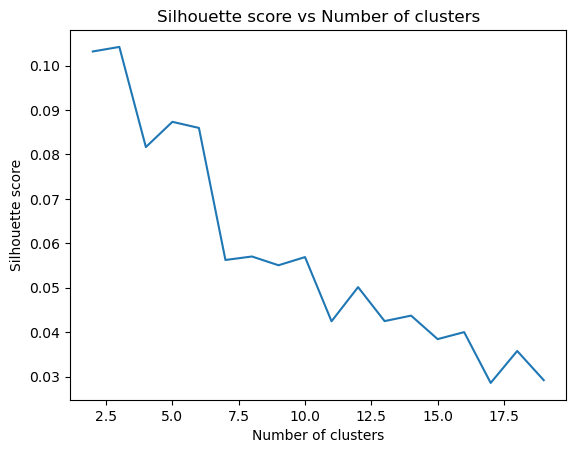

In [20]:
# plot silhouette scores
import matplotlib.pyplot as plt
plt.plot(range(2, 20), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs Number of clusters')
plt.show()

## Visualization

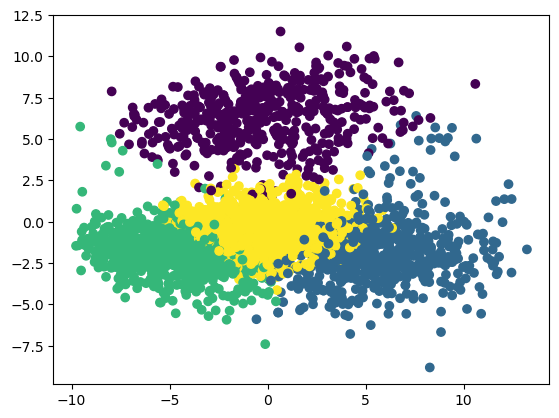

In [22]:
visualize_2d(features, None, labels)

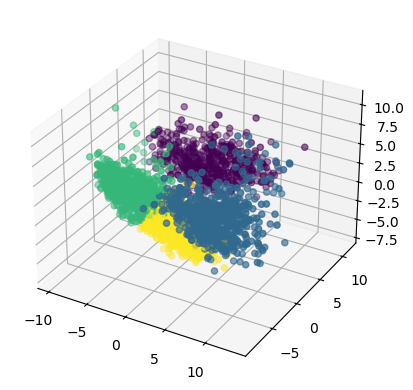

In [23]:
visualize_3d(features, None, labels)

In [24]:
# add labels to df
df['labels'] = labels

In [25]:
df.head()

,Image Name,0,1,2,3,4,5,6,7,8,...,503,504,505,506,507,508,509,510,511,labels
0,10002702_1960-11-09_2012.jpg,0.272667,0.181304,0.522613,0.985274,0.107050,0.359303,0.275444,0.677732,0.263400,...,0.181292,0.383862,0.020063,0.129796,0.336707,0.028761,0.445108,0.010085,0.227951,2
1,1002001_1944-05-01_1995.jpg,0.279749,0.001916,0.115101,0.893894,0.040134,0.333267,0.071751,0.759813,0.170035,...,0.048637,0.739707,0.014779,0.554291,0.208090,0.462767,0.565933,0.023557,0.000000,2
2,1004604_1981-11-27_2012.jpg,0.191526,0.309201,0.144497,1.417195,0.191475,0.046141,0.252428,0.148858,0.103499,...,0.002504,0.347986,0.126279,0.739436,0.297104,0.387431,0.874872,0.032340,0.076012,2
3,10049200_1891-09-16_1958.jpg,0.382820,0.079980,0.591635,0.931270,0.348299,0.317523,0.126595,0.221747,0.059046,...,0.001872,1.560098,0.123703,0.385894,0.007108,0.017871,1.083520,0.023397,0.091238,0
4,10064003_1986-01-04_2009.jpg,0.865130,0.361720,0.539288,1.447548,0.425298,0.970224,0.440898,0.828271,0.076451,...,0.025929,0.740600,0.087209,0.401073,0.026632,0.077148,0.935509,0.135685,0.063321,1
